# 数分割問題に対する量子アニーリングを用いた解法

## 概要

本記事では量子アニーリングマシンによる数分割問題の計算時間を、総当たりによる計算時間と比較することによってその有用性を確認します。

## 文献情報

- タイトル：Ising formulations of many NP problems  
- 著者：Andrew Lucas  
- 書誌情報：https://doi.org/10.3389/fphy.2014.00005

## 環境設定

In [ ]:
!pip install numpy
!pip install matplotlib>=3.5.1  # 3.5.1未満であるとグラフの表示が正常に行われない可能性あり
!pip install pandas
!pip install dwave-ocean-sdk
!pip install openjij

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 31.5 MB/s eta 0:00:00
  Attempting uninstall: networkx
   

In [ ]:
import math
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN
import time

import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from openjij import SASampler

## 問題設定

数分割問題とは、与えられたN個の実数を二つの集合に分けたとき、等分できるかどうかを判定する問題のことです。

数分割問題はNP困難とされています [Lucas, 2014]。NP困難（NP-hard）とはNPに属する任意の問題と比べて、少なくとも同程度以上に難しい問題のことを指します。言いかえると、NPに属する任意の問題がAによって多項式時間で解けるとき、AはNP困難であると言います。ただし、NPとは非決定的アルゴリズムで多項式時間で解ける問題（Non-deterministic Polynomial Time-Solvable）のことであり、ここで言う非決定的アルゴリズムは、同一の入力に対して異なる出力結果を返すアルゴリズムのことです。

以下のようにして平均値Avg、分散VarとなるようなN個のデータCを生成し、それらを整数に丸め込むことで実験用データWを作成しました。数分割問題として、このN個の数値をどのように組み合わせることによって2つのグループに均等に分割できるかを考えます。

In [ ]:
N = 20
Avg = 10
Var = 10

SD = np.sqrt(Var)
C = np.random.normal(loc=Avg, scale=SD, size=N)
W = np.round(C)  # データセットを整数値に丸め込む

In [ ]:
def plot_numbers(numbers):
    x_list = np.arange(len(numbers))
    plt.bar(x_list, numbers, color="skyblue")
    for i, n in enumerate(numbers):
        plt.text(i, n / 2, n, ha="center")
    plt.show()

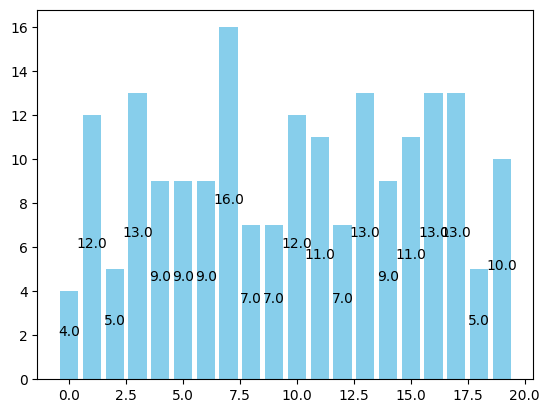

In [ ]:
plot_numbers(W)

In [ ]:
# 生成したデータセットの合計値、平均値、分散を表示
print("合計:\t", sum(W))
print("平均:\t", sum(W) / N)
print("分散:\t", np.var(W))

合計:	 195.0
平均:	 9.75
分散:	 9.8875


## 解法

### ビット全探索

ここでは与えられた数値について、全ての分け方を考えることで最適解を見つけます。以下ではその具体的な内容について述べます。

与えられた数値を2つのグループに分けることを考え、名前をそれぞれ$A,B$とします。$A$と$B$を区別するならば、数値の振り分け方は$2^N$通りあります。

次にグループ分けの表記の仕方について述べます。ここではグループ$A$に所属することを$0$、グループ$B$に所属することを$1$で表現します。まず初めに$0$から$2^N$までの数値を二進数で生成します。生成した二進数に対し$2^k$の位の値（$0$または$1$）を見て、データセットの$k$番目の数値をどちらのグループに割り振るかを決定します。このときデータセット$W$の先頭は0番目であるとし、$k$は$0<k<N-1$を満たすことに注意してください。この操作を$2^0$の位から$2^{N-1}$の位まで行います。さらに、この操作を生成した二進数$0$から$2^{N-1}$まで行います。

ただし、本来ならば2つのグループを区別する必要はありませんが、この計算方法では区別してしまっています。本記事では量子アニーリングとビット全探索の計算時間の差を比較することを目的としており、後述する通りその差は明確です。そのため、今回は総当たり計算の効率を追求することはしません。

以下では，前述したビット全探索によって与えられた数分割問題に対する最適解を取り出します。

In [ ]:
t1 = time.perf_counter()

# 全通りのグループ分けの結果
Group_A_BF = np.zeros(((2**N), N))
Group_B_BF = np.zeros(((2**N), N))

# bitによる組み合わせ
Combo = np.zeros(((2**N), N))

# 2つのグループの差の最小値
Diff_BF = sum(W)

# 最適解のグループ分けの暫定値
note = 0

for i in range(2**N):
    # bitで組み合わせを表現するためにiを2進数に変換し、残りを0で埋める
    Bit = format(i, "b").zfill(N)

    for j in range(N):
        # Bitの0,1に応じて全通りの組合せを保存する
        if Bit[j] == "1":
            Group_A_BF[i][j] = W[j]
        else:
            Group_B_BF[i][j] = W[j]

    # 上で求めた全通りの組合せのうち、差が最小となるものを抽出する
    Diff_tmp = abs(sum(Group_A_BF[i]) - sum(Group_B_BF[i]))

    if Diff_tmp <= Diff_BF:
        Diff_BF = Diff_tmp
        note = i

t2 = time.perf_counter()

# 計算時間を記録する
Time_BF = t2 - t1

もしもここでクラッシュしてしまう場合は、問題サイズを小さくしてください。

最後に先ほど求めた最適解の内の１つを表示します。

In [ ]:
def plot_grouping(A, B, bar_width=0.4, alpha=1):
    df = pd.DataFrame([A, B], index=["A", "B"]).T
    df_nan = df.replace([0], np.nan)

    fig, ax = plt.subplots()

    Sum = np.array([sum(A), sum(B)])

    data_points = np.arange(len(df.columns))
    bottom_data = pd.Series(np.zeros(len(df.columns)), index=df.columns.tolist())

    index = np.array(["A", "B"])

    for i in range(len(df.index)):
        p1 = ax.bar(
            index,
            df.iloc[i],
            bar_width,
            bottom=bottom_data,
            alpha=alpha,
            color="skyblue",
            edgecolor="white",
            linewidth=0.5,
        )
        ax.bar_label(p1, label_type="center")

        bottom_data += df.iloc[i]
        ax.set_xticks(data_points)
        ax.set_xticklabels(df.columns)

    return plt.show()

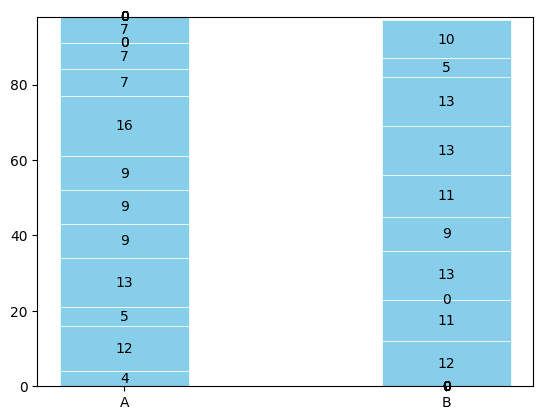

In [ ]:
plot_grouping(Group_A_BF[note], Group_B_BF[note])

In [ ]:
print("合計値の差\t", Diff_BF)
print("計算時間[s]\t", Time_BF)

合計値の差	 1.0
計算時間[s]	 37.245861749


### 量子アニーリング

本記事では、D-Wave Systemsの量子アニーリングマシンを用いて数分割問題に取り組みます。

$0$と$1$のみを取る二値変数$q_i$を用いて、$i$番目の数値$w_i$が$A$に属する場合は$q_i=1$、$B$に属する場合は$q_i=0$と定義します。今回の数分割問題は各グループの総和の差が$0$になることが目標であるため、制約条件として以下のように定式化します。

$$ \sum_{i=1}^N w_i q_i- \sum_{i=1}^N w_i \left(1 - q_i \right) = 0 $$

左辺第一項はグループ$A$の総和、左辺第二項はグループ$B$の総和を表しています。よって数分割問題に対するQUBO(Quadratic Unconstrained Binary Optimization)は以下のようになります。

$$
H \left(q \right) = \left( \sum_{i=1}^N w_i q_i- \sum_{i=1}^N w_i \left(1 - q_i \right) \right)^2 = \left( 2 \sum_{i=1}^N w_i q_i - \sum_{i=1}^N w_i \right)^2
\\= 4 \sum_{i=1}^N w_i \left(w_i - \sum_{j=1}^N w_j \right)q_i + 8 \sum_{i=1}^N \sum_{j=1}^N w_i w_j q_i q_j + \left( \sum_{i=1}^N w_i \right)^2  
$$

なお、上式右辺第三項は定数で$q$に依存しない定数であるため、$H(q)$の最小値を考えるうえで無視することができます。

以下では実際にQUBOを作成します。

In [ ]:
Q = {}
for i in range(N):
    Q[i, i] = 4 * W[i] * (W[i] - sum(W))
    for j in range(i + 1, N):
        Q[i, j] = 8 * W[i] * W[j]

ここで、作成したQUBOを可視化してみます。

In [ ]:
def show_qubo(qubo, cmap=cm.GnBu, save_path=None):
    n_qubo = (
        max(sorted(qubo.keys())[-1][0], sorted(qubo.keys(), key=lambda x: x[1])[-1][1])
        + 1
    )

    np_qubo = np.zeros((n_qubo, n_qubo))
    for (pos_x, pos_y), coeff in qubo.items():
        np_qubo[pos_x][pos_y] = coeff

    plt.imshow(np_qubo, cmap=cmap)
    plt.colorbar()

    if save_path is not None:
        plt.savefig(save_path)

    plt.show()

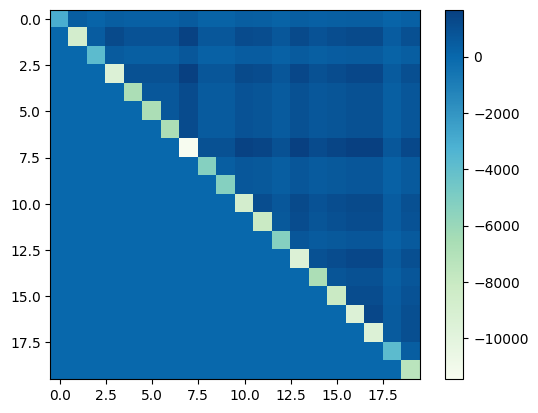

In [ ]:
show_qubo(Q)

これを量子アニーリングマシンに入力し、得られたエネルギーから最適解を見つけます。

まず初めに、先程作成したQUBOをD-Waveに入力します。最初に作成した[D-Wave Leap](https://cloud.dwavesys.com/leap/)のアカウントの接続情報を用いてください。

In [ ]:
# 接続情報
endpoint = "https://cloud.dwavesys.com/sapi"
token = "YOUR_TOKEN"
solver = "Advantage_system6.2"

dw = DWaveSampler(endpoint=endpoint, token=token, solver=solver)

# D-Waveマシンのハードウェアグラフに埋め込みを行う
sampler = EmbeddingComposite(dw)

# 一度に取得するサンプル数
num_reads = 300

# D-Waveマシンのアニーリング時間
annealing_time = 20

# D-Waveマシンによるサンプリングを実行する
response_DW = sampler.sample_qubo(Q, num_reads=num_reads, annealing_time=annealing_time)

SolverAuthenticationError: ignored

次に、アニーリングマシンから返された計算結果を表示します。

In [ ]:
response_DW.to_pandas_dataframe().head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,chain_break_fraction,energy,num_occurrences
0,1,1,0,0,0,1,0,1,0,0,...,1,0,0,1,1,1,1,0.20,-40656.0,7
1,0,0,1,1,1,1,1,0,1,1,...,0,1,1,0,0,0,0,0.20,-41944.0,3
2,0,0,1,1,1,1,1,0,1,1,...,0,1,1,0,0,0,0,0.15,-41944.0,1
3,1,1,0,1,0,1,0,1,0,0,...,1,0,0,1,1,1,1,0.25,-39000.0,6
4,0,0,0,1,1,1,1,0,1,1,...,0,1,1,0,0,0,0,0.20,-42024.0,3


さらに、アニーリングにかかった時間や通信時間を表示します。

In [ ]:
response_DW.info

{'timing': {'qpu_sampling_time': 25896.0,
  'qpu_anneal_time_per_sample': 20.0,
  'qpu_readout_time_per_sample': 45.78,
  'qpu_access_time': 41822.77,
  'qpu_access_overhead_time': 815.23,
  'qpu_programming_time': 15926.77,
  'qpu_delay_time_per_sample': 20.54,
  'post_processing_overhead_time': 1820.0,
  'total_post_processing_time': 1820.0},
 'problem_id': 'c66de046-b25c-48af-ab8c-40ca0194e266'}

続いてアニーリングマシンから返された情報から、各結果のエネルギーを比較し最適解を取り出します。

具体的には、アニーリングマシンが返したすべての解について、そのグループ分けの際の差を計算することで最適解を取り出します。今回は5.1.で用いたビット全探索によって最適解が分かっているため、それを参考にアニーリングマシンによる最適解を抽出します。なお、この方法ではアニーリングマシンが最適解ではなく近似解のみを導出した際に問題が発生します。

そこで最適化も含めて取り出すために、アニーリングマシンが返した全ての結果のエネルギーを比較し、最もエネルギーが低かったものを近似解として出力します。

In [ ]:
# アニーリングマシンから返された結果のエネルギーを計算する関数
def calculate_energy(solution):
    Ene = sum(W) ** 2
    for i in range(N):
        Ene += Q[i, i] * solution[i]
        for j in range(i + 1, N):
            Ene += Q[i, j] * solution[i] * solution[j]
    return Ene

In [ ]:
# 最適解と近似解の個数をカウントする関数
def count_solutions(response):
    # 最適解と近似解の個数
    num_optimal_sol = 0
    num_approx_sol = 0

    # 最適解と近似解
    optimal_sol = []
    approx_sol = []

    # エネルギー
    Energies = []

    for state in response.record:
        energy = calculate_energy(state.sample)

        # 出現回数分だけエネルギーを加えることで、後で全体のエネルギー分布を把握する
        Energies += [energy] * state.num_occurrences

    # ビット全探索の結果を元に、最適解を見つける
    for state in response.record:
        energy = calculate_energy(state.sample)

        if energy == Diff_BF:
            num_optimal_sol += state.num_occurrences
            optimal_sol.append(state.sample)

        if energy == min(Energies):
            num_approx_sol += state.num_occurrences
            approx_sol.append(state.sample)

    return num_optimal_sol, num_approx_sol, optimal_sol, approx_sol, Energies

In [ ]:
num_optimal_sol, num_approx_sol, optimal_sol, approx_sol, Energies = count_solutions(
    response_DW
)

print("最適解（個）\t", num_optimal_sol)
print("近似解（個）\t", num_approx_sol)

最適解（個）	 30
近似解（個）	 30


後述しますが、TTSと呼ばれる指標を計算する際にここで最適解を少なくとも１つ以上出す必要があります。もし最適解が得られなかった場合は、アニーリングマシンを再度動かしてみましょう。

得られた最適解は$0,1$の組合せが表現されているだけで、どの数値に対応しているかまでの情報を保持していないので、以下ではグループ分けの仕方とその数値を対応させます。

In [ ]:
Group_A_DW = []
Group_B_DW = []

for solution in approx_sol:
    Group_A = np.zeros(N)
    Group_B = np.zeros(N)

    for i in range(N):
        if solution[i] == 1:
            Group_A[i] = W[i]
        else:
            Group_B[i] = W[i]

    Group_A_DW.append(Group_A)
    Group_B_DW.append(Group_B)

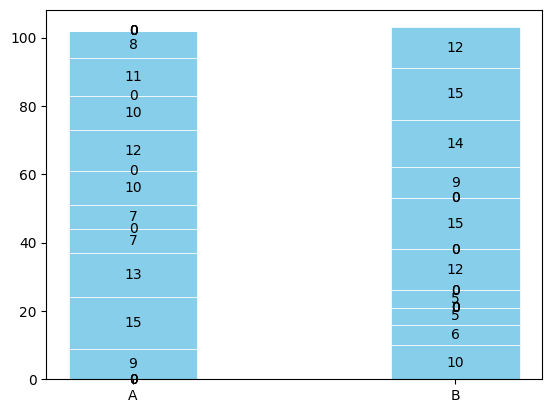

In [ ]:
# 得られた近似解の組合せを1つ表示する
S = 0  # 解のインデックス (0 <= S <= num_optimal_sol - 1)
plot_grouping(Group_A_DW[S], Group_B_DW[S])

In [ ]:
print("2つのグループの合計値の差\t", abs(sum(Group_A_DW[S]) - sum(Group_B_DW[S])))
print("計算時間（理論値）[s]\t", annealing_time * num_reads / 10**6)
print("計算時間（実測値）[s]\t", response_DW.info["timing"]["qpu_sampling_time"] / 10**6)

2つのグループの合計値の差	 1.0
計算時間（理論値）[s]	 0.006
計算時間（実測値）[s]	 0.025896


ビット全探索時に比べて、アニーリングマシンによる手法は短時間で最適解を導出可能なことが分かります。

続いてアニーリングマシンで得られた解の分布の様子を観察してみます。エネルギーが小さいほど、2つのグループの値の差が小さいことを表します。

In [ ]:
# 解のエネルギー分布を可視化する関数
def plot_energies(energies):
    plt.hist(energies, color="skyblue")
    plt.xlabel("Energy")
    plt.ylabel("Frequency")
    plt.show()

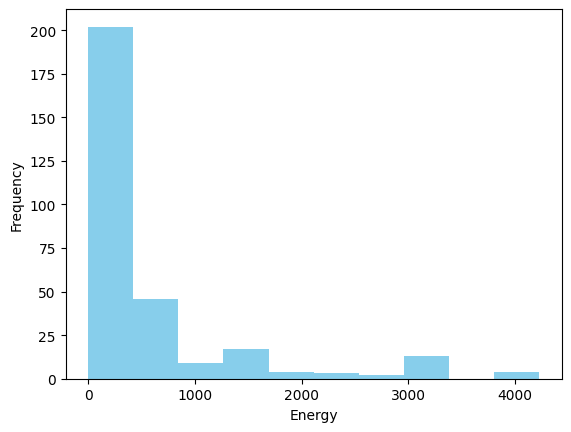

In [ ]:
plot_energies(Energies)

最後に、量子アニーリングマシンのベンチマークとして、確率$p_d$で最適解が得られるまでの計算時間TTS(Time to solution)を求めます。


１回のアニーリングの時間を$\tau[s]$で最適解が得られる確率を$P_s \left(\tau \right)$とすると、$R$回のアニーリングにおいて最適解が１回も得られない確率は$\left(1-P_s \left(\tau \right) \right)^R$で表されます。ここで、$R$回のアニーリングのうち、１回は最適解が得られる確率を一般に$p_d$とすると、$p_d$は次式で表されます。

$$ p_d = 1 - \left(1 - P_s \left(\tau \right) \right)^R $$

よって、確率$p_d$で最適解を得られる試行回数$R$は、以下のように求められます。

$$ R = \frac{\ln(1 - p_d)}{\ln(1-P_s(\tau))} $$

以上により、$p_d$の確率で最適解が求まる計算時間$TTS(\tau,p_d)$は、以下の式で与えられます。

$$TTS(\tau,p_d) = \tau R = \tau \frac{\ln(1-p_d)}{\ln(1-P_s(\tau))}$$

　TTSを導出するにあたって、上記で得られた最適解の個数が0の場合は計算ができません。これは$P_s \left(\tau \right)$を導出できないことに原因があります。再びアニーリングマシンを動かして、計算し直してください。

In [ ]:
# TTSを計算する関数（Tau[s]）
def calculate_TTS(p_d, Tau, p_s):
    if p_s == 0:
        raise ValueError("p_s!=0 is required")
    return Tau * np.log(1 - p_d) / np.log(1 - p_s)

In [ ]:
p_d = 0.99  # 0.99の場合、99%の確率で最適解が得られるまでの計算時間
Tau = annealing_time * 10 ** (-6)
p_s = num_optimal_sol / num_reads

print("TTS[µs]", calculate_TTS(p_d, Tau, p_s) * 10**6)

TTS[µs] 874.1738130713132


TTSの計算によって、99%の確率で最適解が得られる計算時間が分かりました。今回の計算時間（理論値）は6000[µs]であったので、最適解が得られる確率は99%よりは低かったことが考えられます。

### シミュレーテッドアニーリング

　量子アニーリングの時と同様にQUBOを作成します。

In [ ]:
# SAをサンプラーとして選択
sampler = SASampler()

# 一度に取得するサンプル数
num_reads = 300

# アニーリング中のパラメータ(温度, 横磁場)を下げていくときの分割数
# この値を増やすほどゆっくりアニーリングをすることに相当し、アニーリング時間が伸びる
num_sweeps = 50

# SAによるサンプリングを実行する
response_SA = sampler.sample_qubo(Q, num_reads=num_reads, num_sweeps=num_sweeps)

In [ ]:
response_SA.to_pandas_dataframe().head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,energy,num_occurrences
0,0,0,0,0,1,0,1,0,1,1,...,0,1,1,1,0,1,0,1,-38016.0,1
1,1,1,0,1,1,1,0,0,0,0,...,1,0,1,0,0,1,0,1,-38024.0,1
2,1,1,0,1,0,1,1,1,1,1,...,0,0,0,1,0,0,0,1,-38024.0,1
3,1,1,0,0,0,1,1,1,1,1,...,1,0,0,0,1,1,0,0,-38024.0,1
4,0,1,0,0,1,0,0,1,0,0,...,1,1,0,0,0,1,1,0,-38024.0,1


In [ ]:
num_optimal_sol, num_approx_sol, optimal_sol, approx_sol, Energies = count_solutions(
    response_SA
)

print("最適解（個）\t", num_optimal_sol)
print("最適解（個）\t", num_approx_sol)

最適解（個）	 150
最適解（個）	 150


In [ ]:
Group_A_SA = []
Group_B_SA = []

for solution in approx_sol:
    Group_A = np.zeros(N)
    Group_B = np.zeros(N)

    for i in range(N):
        if solution[i] == 1:
            Group_A[i] = W[i]
        else:
            Group_B[i] = W[i]

    Group_A_SA.append(Group_A)
    Group_B_SA.append(Group_B)

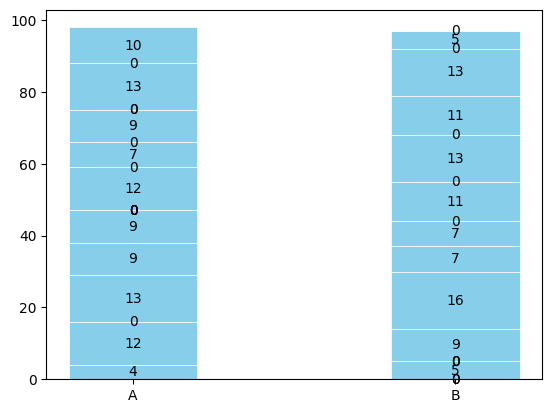

In [ ]:
# 得られた近似解の組合せを1つ表示する
S = 0  # 解のインデックス (0 <= S <= num_optimal_sol - 1)
plot_grouping(Group_A_SA[S], Group_B_SA[S])

In [ ]:
print("2つのグループの合計値の差\t", abs(sum(Group_A_SA[S]) - sum(Group_B_SA[S])))
print("計算時間[µs]\t", response_SA.info["execution_time"])

2つのグループの合計値の差	 1.0
計算時間[µs]	 60.54146000015711


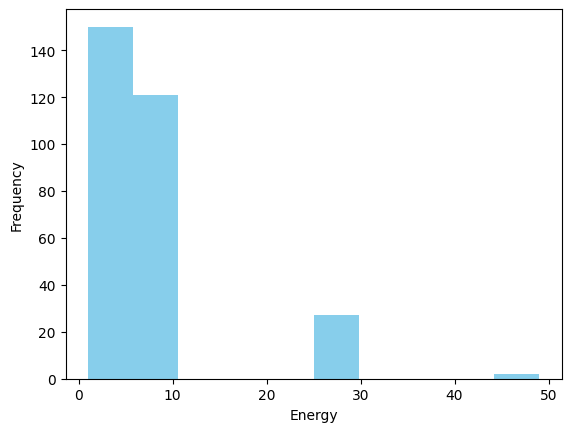

In [ ]:
plot_energies(Energies)

シミュレーテッドアニーリングを用いても量子アニーリングと同様に計算することができました。

## あとがき

今回は量子アニーリングマシンを実際に使ってみることを目標として数分割問題に取り組みました。得られた解を評価する方法として、TTSを用いることができ、TTSに対して改めて理解する良い機会もありました。二つの計算方法の比較としては、計算時間の差が予想以上に大きく、成果が目に見えるような面白い結果となりました。